# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv(r"C:\Users\rsach\OneDrive\Desktop\AI & ML\5. ML 2\telecom-churn-case-study-hackathon-c-67\train.csv")
unseen = pd.read_csv(r"C:\Users\rsach\OneDrive\Desktop\AI & ML\5. ML 2\telecom-churn-case-study-hackathon-c-67\test.csv")
sample = pd.read_csv(r"C:\Users\rsach\OneDrive\Desktop\AI & ML\5. ML 2\telecom-churn-case-study-hackathon-c-67\sample.csv")
data_dict = pd.read_csv(r"c:\Users\rsach\OneDrive\Desktop\AI & ML\5. ML 2\telecom-churn-case-study-hackathon-c-67\data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [3]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [5]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [6]:
data['churn_probability'].value_counts()

churn_probability
0    62867
1     7132
Name: count, dtype: int64

In [7]:
missing_percentage = data.isnull().sum() / len(data) * 100

# Iterate through the columns and drop those with more than 70% missing values
columns_to_drop = [col for col in data.columns if missing_percentage[col] > 70]
data = data.drop(columns=columns_to_drop, axis =1)

# Print the columns that were dropped
print(f"Dropped columns: {columns_to_drop}")


Dropped columns: ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']


In [8]:
data = data.drop(["id", "circle_id"], axis =1)

Let's look at each variable's datatype:

In [9]:
data.select_dtypes(include =['object'])

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,6/30/2014,7/31/2014,8/31/2014,6/22/2014,7/10/2014,8/24/2014
1,6/30/2014,7/31/2014,8/31/2014,6/12/2014,7/10/2014,8/26/2014
2,6/30/2014,7/31/2014,8/31/2014,6/11/2014,7/22/2014,8/24/2014
3,6/30/2014,7/31/2014,8/31/2014,6/15/2014,7/21/2014,8/25/2014
4,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/26/2014,8/30/2014
...,...,...,...,...,...,...
69994,6/30/2014,7/31/2014,8/31/2014,6/18/2014,7/31/2014,8/31/2014
69995,6/30/2014,7/31/2014,8/31/2014,6/28/2014,7/31/2014,8/27/2014
69996,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/30/2014,8/29/2014
69997,6/30/2014,7/31/2014,8/31/2014,6/29/2014,7/19/2014,8/26/2014


In [10]:
# Since we are classifying customer churn probability
data[data.select_dtypes(include=['object']).columns] = data.select_dtypes(include=['object']).apply(
    lambda col: pd.to_datetime(col, format='%m/%d/%Y', errors='coerce')
)

# Print the updated DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 140 entries, loc_og_t2o_mou to churn_probability
dtypes: datetime64[ns](6), float64(108), int64(26)
memory usage: 74.8 MB
None


In [11]:
data["days_difer_1"] = data["date_of_last_rech_7"] - data["date_of_last_rech_6"]
data["days_difer_1"] = data["days_difer_1"].dt.days

In [12]:
data["days_difer_2"] = (data["date_of_last_rech_8"] - data["date_of_last_rech_7"]).dt.days

In [13]:
# dropping unnecessary columns
data = data.drop(["date_of_last_rech_7", "date_of_last_rech_6", "date_of_last_rech_8","last_date_of_month_6", "last_date_of_month_7", "last_date_of_month_8" ], axis =1)
data.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_difer_1,days_difer_2
0,0.0,0.0,0.0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,...,0,0,0,1958,0.0,0.0,0.0,0,18.0,45.0
1,0.0,0.0,0.0,0.000,122.787,42.953,0.00,0.00,0.00,0.00,...,0,0,0,710,0.0,0.0,0.0,0,28.0,47.0
2,0.0,0.0,0.0,60.806,103.176,0.000,0.53,15.93,0.00,53.99,...,0,0,0,882,0.0,0.0,0.0,0,41.0,33.0
3,0.0,0.0,0.0,156.362,205.260,111.095,7.26,16.01,0.00,68.76,...,0,0,0,982,0.0,0.0,0.0,0,36.0,35.0
4,0.0,0.0,0.0,240.708,128.191,101.565,21.28,4.83,6.13,56.99,...,0,1,0,647,0.0,0.0,0.0,0,31.0,35.0


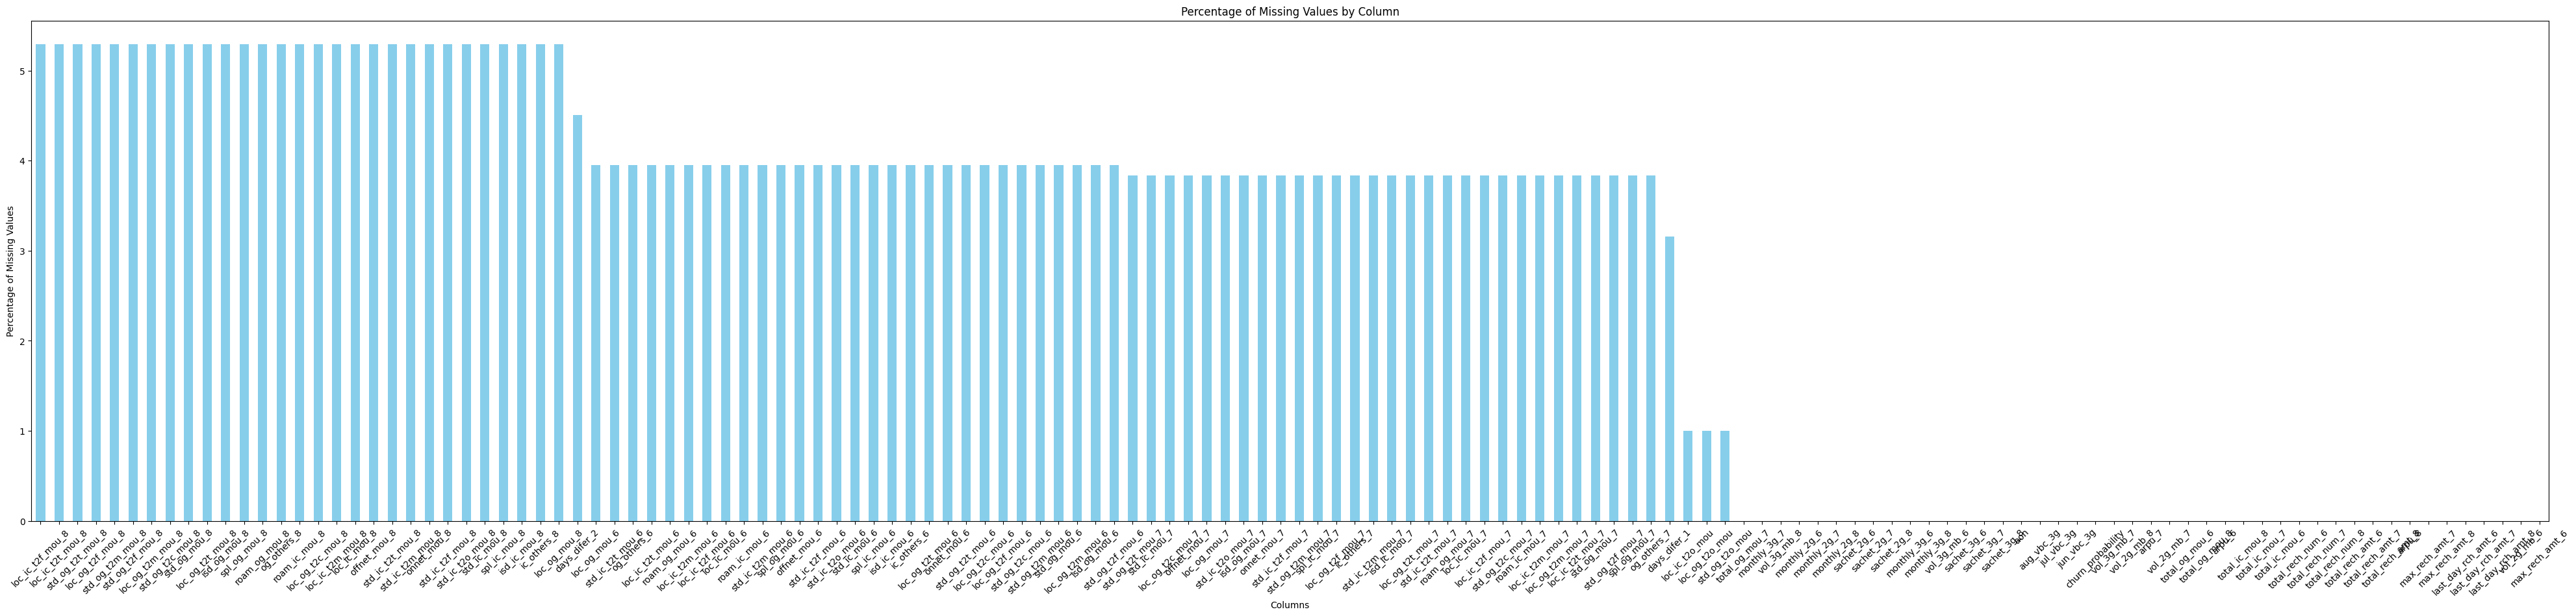

In [14]:
# Calculate percentage of missing values
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Plot the bar chart
plt.figure(figsize=(50,10))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45)
plt.show()

In [15]:
# impute missing values with median
data.fillna(data.median(), inplace= True)

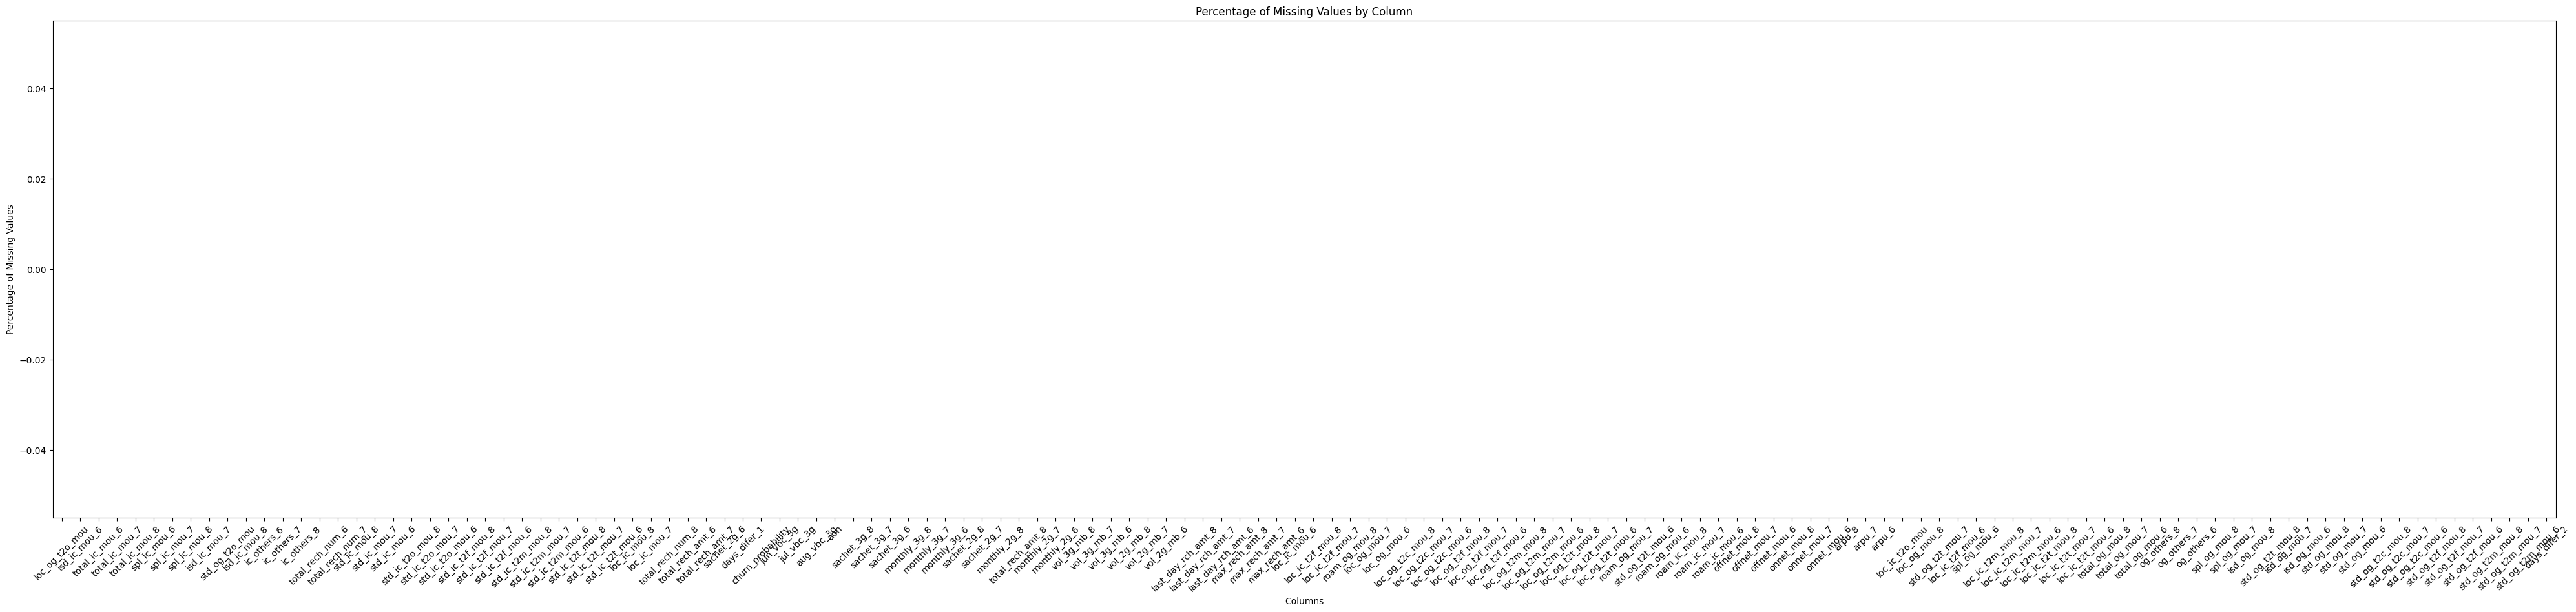

In [16]:
# Calculate percentage of missing values
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Plot the bar chart
plt.figure(figsize=(50,10))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45)
plt.show()

In [17]:
data['churn_probability'].value_counts()

churn_probability
0    62867
1     7132
Name: count, dtype: int64

In [18]:
data.describe()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_difer_1,days_difer_2
count,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000,69999.000000,69999.000000
mean,0.0,0.0,0.0,283.134365,278.185912,278.858826,129.236765,129.993840,127.641721,194.825731,...,0.075344,0.081444,0.085487,1220.639709,68.108597,65.935830,60.07674,0.101887,31.304319,30.831726
std,0.0,0.0,0.0,334.213918,344.366927,351.924315,294.605405,305.867956,304.373330,311.131642,...,0.573003,0.634547,0.680035,952.426321,269.328659,267.899034,257.22681,0.302502,6.996486,7.084112
min,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000
25%,0.0,0.0,0.0,93.581000,86.714000,84.095000,8.060000,7.260000,7.360000,36.880000,...,0.000000,0.000000,0.000000,468.000000,0.000000,0.000000,0.00000,0.000000,28.000000,28.000000
50%,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,96.480000,...,0.000000,0.000000,0.000000,868.000000,0.000000,0.000000,0.00000,0.000000,31.000000,31.000000
75%,0.0,0.0,0.0,370.791000,365.369500,369.909000,113.100000,108.940000,106.280000,223.540000,...,0.000000,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000,34.000000,34.000000
max,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,...,29.000000,33.000000,41.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000,60.000000,61.000000


In [19]:
data.isnull().sum()

loc_og_t2o_mou       0
std_og_t2o_mou       0
loc_ic_t2o_mou       0
arpu_6               0
arpu_7               0
                    ..
jul_vbc_3g           0
jun_vbc_3g           0
churn_probability    0
days_difer_1         0
days_difer_2         0
Length: 136, dtype: int64

# 2. Create Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

Splitting train and test data to avoid any contamination of the test data

In [20]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data.shape,test_data.shape

((55999, 136), (14000, 136))

In [21]:
train_data.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_difer_1,days_difer_2
47338,0.0,0.0,0.0,172.250,149.720,244.222,20.71,13.16,48.34,152.38,...,0,0,0,395,0.0,0.0,0.0,0,28.0,12.0
67455,0.0,0.0,0.0,155.610,53.934,47.532,11.84,7.54,5.33,107.69,...,0,0,0,515,0.0,0.0,0.0,0,21.0,38.0
12308,0.0,0.0,0.0,68.285,71.308,35.515,12.64,5.63,0.00,23.16,...,0,0,0,595,0.0,0.0,0.0,0,30.0,12.0
52334,0.0,0.0,0.0,139.165,205.666,172.807,68.78,207.41,57.04,172.33,...,0,0,0,656,0.0,0.0,0.0,0,24.0,32.0
664,0.0,0.0,0.0,475.536,137.251,0.000,25.26,11.58,32.10,574.48,...,0,0,0,499,0.0,0.0,0.0,1,17.0,34.0


# 3. Exploratory Data Analysis & Preprocessing

Lets start by analysing the outlier distributions of each feature.

In [22]:
from scipy.stats import zscore

In [23]:
# Calculate Z-scores column-wise
z_scores = train_data.apply(zscore)
z_scores

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_difer_1,days_difer_2
47338,NaN,NaN,NaN,-0.346669,-0.407589,-0.103452,-0.368931,-0.381712,-0.259035,-0.137014,...,-0.130211,-0.126135,-0.125926,-0.866522,-0.253329,-0.249083,-0.236140,-0.336962,-0.476196,-2.652833
67455,NaN,NaN,NaN,-0.398774,-0.711390,-0.702719,-0.399225,-0.400042,-0.399224,-0.279435,...,-0.130211,-0.126135,-0.125926,-0.740260,-0.253329,-0.249083,-0.236140,-0.336962,-1.478135,1.013444
12308,NaN,NaN,NaN,-0.672215,-0.656286,-0.739332,-0.396493,-0.406271,-0.416596,-0.548819,...,-0.130211,-0.126135,-0.125926,-0.656085,-0.253329,-0.249083,-0.236140,-0.336962,-0.189927,-2.652833
52334,NaN,NaN,NaN,-0.450268,-0.230146,-0.321037,-0.204754,0.251852,-0.230678,-0.073437,...,-0.130211,-0.126135,-0.125926,-0.591902,-0.253329,-0.249083,-0.236140,-0.336962,-1.048732,0.167380
664,NaN,NaN,NaN,0.603014,-0.447136,-0.847538,-0.353391,-0.386865,-0.311968,1.208156,...,-0.130211,-0.126135,-0.125926,-0.757095,-0.253329,-0.249083,-0.236140,2.967689,-2.050672,0.449401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,NaN,NaN,NaN,0.685612,0.568710,0.783557,1.603103,0.500939,0.548655,-0.219522,...,-0.130211,-0.126135,-0.125926,-0.060548,-0.253329,-0.249083,-0.236140,2.967689,0.096341,1.154455
6265,NaN,NaN,NaN,-0.770598,-0.508432,-0.560098,-0.377811,-0.250107,-0.245378,-0.580433,...,-0.130211,-0.126135,-0.125926,-0.804443,-0.253329,-0.249083,-0.236140,-0.336962,-1.478135,1.013444
54886,NaN,NaN,NaN,-0.002506,-0.468764,0.012014,-0.439663,-0.424634,-0.416596,-0.622627,...,-0.130211,-0.126135,-0.125926,-0.875992,3.842972,3.351725,4.827383,-0.336962,-0.762464,2.141529
860,NaN,NaN,NaN,0.835057,0.915104,0.240423,-0.264010,0.051656,-0.346812,-0.575015,...,3.341197,4.534157,-0.125926,2.015415,0.484242,0.460159,2.438944,-0.336962,-0.619330,0.167380


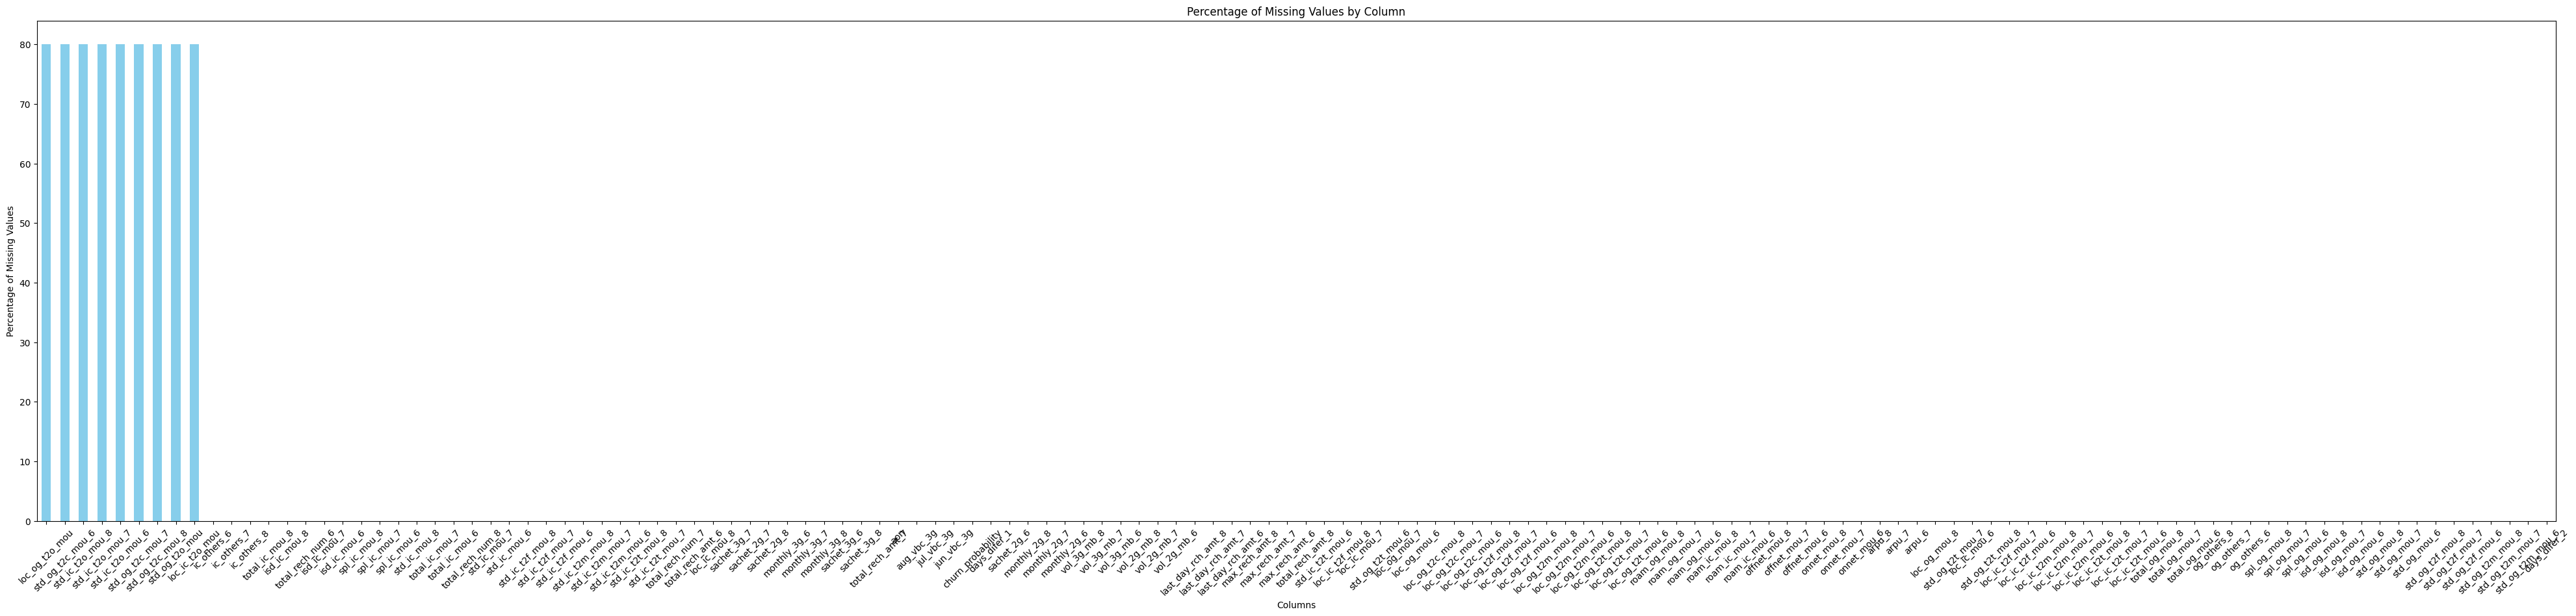

In [24]:
# Calculate percentage of missing values
missing_percentage = (z_scores.isnull().sum() / len(data)) * 100

# Plot the bar chart
plt.figure(figsize=(50,10))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45)
plt.show()

In [25]:
missing_percentage = z_scores.isnull().sum() / len(data) * 100

# Iterate through the columns and drop those with more than 70% missing values
columns_to_drop = [col for col in z_scores.columns if missing_percentage[col] > 50]
z_scores = z_scores.drop(columns=columns_to_drop, axis =1)

# Print the columns that were dropped
print(f"Dropped columns: {columns_to_drop}")

Dropped columns: ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


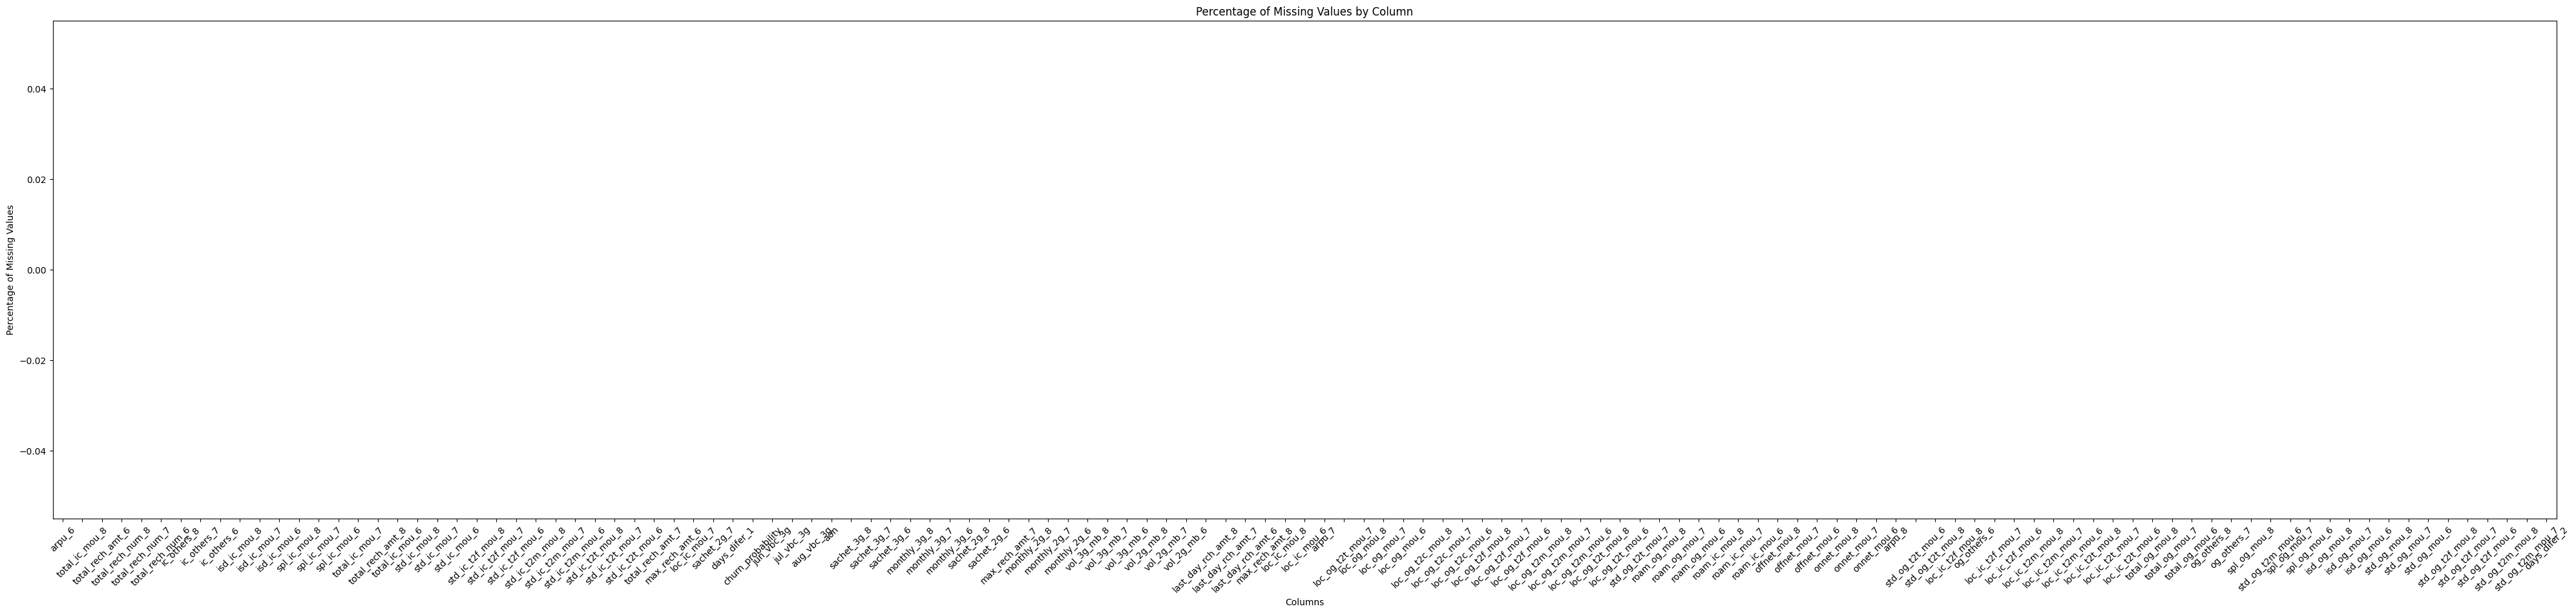

In [26]:
# Calculate percentage of missing values
missing_percentage = (z_scores.isnull().sum() / len(data)) * 100

# Plot the bar chart
plt.figure(figsize=(50,10))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45)
plt.show()

In [27]:
# Filter rows where all Z-scores are within the threshold (-3 to 3)
data_no_outliers = train_data[(abs(z_scores) < 3).all(axis=1)]

# Display the cleaned dataset
data_no_outliers.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_difer_1,days_difer_2
12308,0.0,0.0,0.0,68.285,71.308,35.515,12.64,5.63,0.00,23.16,...,0,0,0,595,0.0,0.0,0.0,0,30.0,12.0
52334,0.0,0.0,0.0,139.165,205.666,172.807,68.78,207.41,57.04,172.33,...,0,0,0,656,0.0,0.0,0.0,0,24.0,32.0
51051,0.0,0.0,0.0,95.200,312.749,290.113,98.31,467.06,427.08,109.04,...,0,0,0,1330,0.0,0.0,0.0,0,32.0,35.0
23680,0.0,0.0,0.0,6.500,65.286,307.000,0.00,20.94,254.89,1.56,...,0,0,0,1578,0.0,0.0,0.0,0,43.0,28.0
26306,0.0,0.0,0.0,40.641,44.986,81.410,4.73,12.46,22.83,44.09,...,0,0,0,277,0.0,0.0,0.0,0,47.0,26.0


In [28]:
data_no_outliers['churn_probability'].value_counts()

churn_probability
0    24192
1     3194
Name: count, dtype: int64

<Axes: >

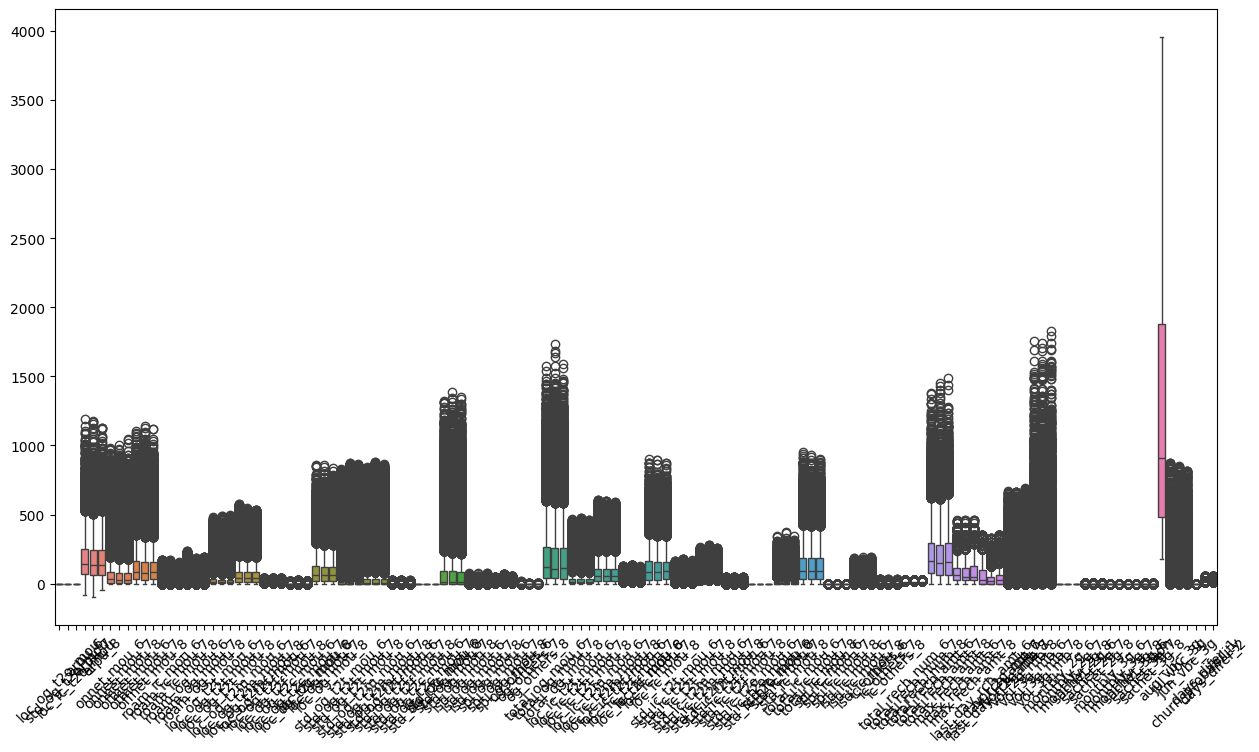

In [29]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = data_no_outliers)

In [30]:
data_no_outliers.shape

(27386, 136)

# 4 Splitting into X and Y

In [31]:
y_train = data_no_outliers.pop('churn_probability')
X_train = data_no_outliers

In [32]:
X_train.shape, y_train.shape

((27386, 135), (27386,))

In [33]:
X_col = X_train.columns
X_col

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6',
       ...
       'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon',
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'days_difer_1',
       'days_difer_2'],
      dtype='object', length=135)

In [34]:
y_test = test_data.pop('churn_probability')
X_test = test_data
X_test.shape, y_test.shape

((14000, 135), (14000,))

### 4.1 Apply SMOTE for Class balancing

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

In [36]:
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [37]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_bal)

In [38]:
X_test_scaled = scale.transform(X_test)

In [39]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [40]:
pca_data = pd.DataFrame(X_train_pca)
pca_data

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,-2.156467,-0.388639,0.121132,-1.804775,2.419997,0.657133,0.625728,2.000212,-0.910670,-0.512341,...,0.707083,0.813973,0.373782,0.147869,-0.397099,-0.245499,0.400249,-0.354803,-0.478666,-0.130804
1,-0.436484,4.718649,-1.140924,-0.191928,-0.580926,-0.922055,0.873221,0.643353,-1.567238,0.379218,...,-0.320702,-0.392462,0.088418,-0.231533,-0.765281,-0.040017,-0.164914,-0.180818,-0.056596,0.092496
2,8.914992,6.212976,-3.825134,-5.737932,7.917145,-0.920905,-2.936263,-0.817089,-1.991952,0.951401,...,-0.203807,-2.397701,-0.364622,-1.278557,1.622256,0.463007,0.603784,-0.210622,0.142024,0.130317
3,-1.061173,0.962106,-4.488412,-0.491942,-2.561253,-0.672427,-0.866037,-0.647026,-0.225342,0.045881,...,0.163317,0.404831,0.873567,-0.628649,0.483092,0.218373,0.018186,0.258302,0.042130,-0.180704
4,-2.662121,-0.866874,-1.491127,-0.333538,-1.036236,-0.014862,0.538677,0.745468,-0.711489,-0.309688,...,-0.081583,-0.008104,0.214848,-0.210255,-0.057071,0.246509,-0.237002,0.076786,0.084645,-0.161139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48379,-3.541241,-1.577644,-0.879877,4.176727,2.574031,1.010621,0.194267,-1.061776,-1.385470,0.001884,...,0.171814,-0.439770,1.121085,0.713460,0.418417,0.907388,-0.448890,-0.561034,0.161382,-0.000752
48380,-1.902599,-1.706517,-1.089743,6.118149,1.375825,-1.871065,-1.259879,0.734430,-4.300302,-1.659800,...,-0.236797,0.630899,-1.195348,-1.346206,-0.414884,0.665092,-0.532478,1.113148,-1.174753,0.771781
48381,3.495143,4.916488,1.518139,-3.048680,7.915653,-4.048774,-0.653141,-5.703874,-0.227411,1.189443,...,-0.266265,-1.783974,-0.442415,-0.061177,0.430474,-0.426313,0.044605,-0.022766,-0.310350,-0.050728
48382,-3.383310,0.324445,-1.419958,-0.992513,-0.696260,0.341685,0.682737,1.555626,-0.832739,-0.497761,...,0.069691,0.227743,-0.071862,0.115166,0.210664,0.041163,-0.058775,0.035582,0.027747,0.027986


In [41]:
# There are 60 significant components as per PCA result for our model
y_train_bal.value_counts()

churn_probability
0    24192
1    24192
Name: count, dtype: int64

<Axes: >

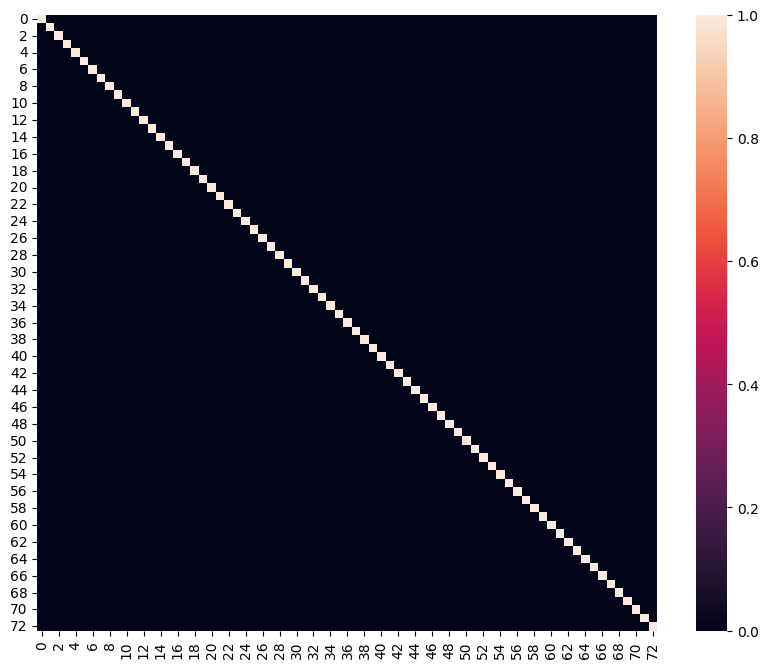

In [42]:
plt.figure(figsize=(10,8))
sns.heatmap(pca_data.corr())

# 5. Model Building

Random forest classifier with grid search

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
rf = RandomForestClassifier(max_features='sqrt',class_weight='balanced',random_state = 42,oob_score=True)
# Define the parameter grid
param_dist = {
    'n_estimators': [500,600],          # Number of trees in the forest
    'max_depth': [20, 30, 40],         # Maximum depth of the tree
    'min_samples_leaf': [2, 4],           # Minimum number of samples required at a leaf node
}

In [45]:
# Set up RandomsearchCV
random_search = RandomizedSearchCV(estimator=rf, 
                           param_distributions = param_dist,
                           n_iter=50,
                           cv=4,                   # 5-fold cross-validation
                           scoring='accuracy',     # Evaluation metric
                           verbose=1,              # Print progress
                           n_jobs=-1)              # Use all available cores

# Fit the model on the training data
random_search.fit(X_train_pca, y_train_bal)


Fitting 4 folds for each of 12 candidates, totalling 48 fits


RandomizedSearchCV(cv=4,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    oob_score=True,
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [20, 30, 40],
                                        'min_samples_leaf': [2, 4],
                                        'n_estimators': [500, 600]},
                   scoring='accuracy', verbose=1)

In [46]:
# Display the best parameters
print("Best Parameters:", random_search.best_params_)

# Get the best model
best_rf = random_search.best_estimator_

Best Parameters: {'n_estimators': 500, 'min_samples_leaf': 2, 'max_depth': 40}


In [47]:
best_rf.fit(X_train_pca, y_train_bal)

RandomForestClassifier(class_weight='balanced', max_depth=40,
                       min_samples_leaf=2, n_estimators=500, oob_score=True,
                       random_state=42)

In [48]:
y_train_pred = best_rf.predict(X_train_pca)
y_train_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [49]:
accuracy_score(y_train_bal,y_train_pred)

0.9992559523809523

In [50]:
y_test_pred = best_rf.predict(X_test_pca)

In [51]:
accuracy_score(y_test,y_test_pred)

0.9105714285714286

In [52]:
from xgboost import XGBClassifier


In [58]:
# Define the XGBoost model
xgb_model = XGBClassifier( eval_metric="logloss")

In [59]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [80]:
# Define the parameter grid
params1 = {
    'n_estimators': [300],        # Number of trees
    'learning_rate': [0.2, 0.4,0.6],     # Step size shrinkage
    'max_depth': [20,30],               # Maximum tree depth
    'subsample': [1.0],               # Fraction of samples used for training each tree
    'reg_alpha': [0.01],           # L1 regularization term
    'reg_lambda': [2.4, 2.8, 5, 10]}            # L2 regularization term

In [81]:
# Set up GridSearchCV
Grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params1,
    cv=3,                   # 3-fold cross-validation
    scoring='accuracy',     # Evaluation metric
    verbose=2,              # Print progress
    n_jobs=-1)               # Use all available cores
# Fit the model on the training data
Grid_search.fit(X_train_pca, y_train_bal)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

In [71]:
# Display the best parameters
print("Best Parameters:", Grid_search.best_params_)

# Get the best model
best_xgb = Grid_search.best_estimator_

Best Parameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 2.0, 'subsample': 1.0}


In [72]:
y_train_pred = best_xgb.predict(X_train_pca)
accuracy_score(y_train_bal, y_train_pred)

1.0

In [73]:
y_test_pred = best_xgb.predict(X_test_pca)

In [74]:
accuracy_score(y_test,y_test_pred)

0.9109285714285714

The model has 90% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [61]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(0.95)
model = best_rf

In [62]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',model)])

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
train_score = pipe.score(X_train, y_train)
print("Training accuracy:", train_score)

In [ ]:
test_score = pipe.score(X_test, y_test)
print("Test accuracy:", test_score)

Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [ ]:
confusion_matrix(y_train, pipe.predict(X_train))

In [ ]:
confusion_matrix(y_test, pipe.predict(X_test))

In [ ]:
precision_score(y_test, pipe.predict(X_test))

In [ ]:
recall_score(y_test, pipe.predict(X_test))

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [ ]:
submission_data = unseen.set_index('id')
# Since we are classifying customer churn probability
submission_data[submission_data.select_dtypes(include=['object']).columns] = submission_data.select_dtypes(include=['object']).apply(
    lambda col: pd.to_datetime(col, format='%m/%d/%Y', errors='coerce')
)

# Print the updated DataFrame
print(data.info())


In [81]:
submission_data["days_difer_1"] = submission_data["date_of_last_rech_7"] - submission_data["date_of_last_rech_6"]
submission_data["days_difer_1"] = submission_data["days_difer_1"].dt.days

In [83]:
submission_data["days_difer_2"] = (submission_data["date_of_last_rech_8"] - submission_data["date_of_last_rech_7"]).dt.days

In [ ]:
# dropping unnecessary columns
submission_data = submission_data.drop(["date_of_last_rech_7", "date_of_last_rech_6", "date_of_last_rech_8","last_date_of_month_6", "last_date_of_month_7", "last_date_of_month_8" ], axis =1)
submission_data.head()

In [85]:
submission_data = submission_data[X_col]

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

In [ ]:
output['churn_probability'].value_counts()

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [88]:
output.to_csv('submission_telecom_churn_SMOTE_pca_rf.csv',index=False)